# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree

from imblearn.under_sampling import RandomUnderSampler

# Modèle de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [3]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# paramètre à initialiser pour définir la règle d'évaluation des modèles
scoring = 'accuracy' # considéré dans le cadre de cette étude
# scoring = 'f1'

### Arbres de décision

In [13]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight={0:2, 1:1})

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt, scoring=scoring)

In [14]:
start_time = time.time()

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 4} 

Accuracy Score: 0.8191632928475033 

Train Data Score: 0.7330533893221356
Test Data Score: 0.8191632928475033

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            19378  2584
1             2508  3688

               precision    recall  f1-score   support

           0       0.89      0.88      0.88     21962
           1       0.59      0.60      0.59      6196

    accuracy                           0.82     28158
   macro avg       0.74      0.74      0.74     28158
weighted avg       0.82      0.82      0.82     28158

Running Time: 0:00:02.470163


- la méthode des arbres de décision **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.60.
- la spécificité (taux de vrais négatifs) vaut 0.88.
- le F1-score concernant la classe '0' de la variable "RainTomorrow" est bon (0.88).
- le F1-score concernant la classe '1' de la variable "RainTomorrow" est très faible (0.59).

La classe '1' est caractérisée par une précision faible, ce qui signifie que la classe n'est pas bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

### Interprétation du modèle

In [15]:
# importance des variables dans le jeu de données d'entraînement
clf_dt = gcv_dt.best_estimator_

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.716317
WindGustSpeed,0.102570
Sunshine,0.099651
Rainfall,0.040769
Pressure9am,0.040694
Cloud3pm,0.000000
Temp3pm,0.000000
Temp_Delta_MinMax,0.000000


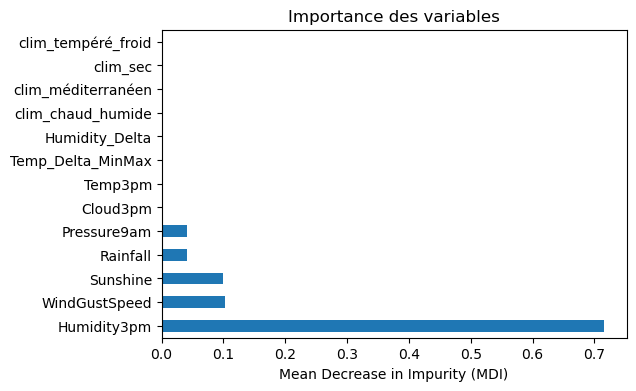

In [16]:
# affichage de l'importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
feature_imp = pd.Series(clf_dt.feature_importances_, index=data.columns)
feature_imp.nlargest(13).plot(kind='barh')
plt.title("Importance des variables")
plt.xlabel("Mean Decrease in Impurity (MDI)");

Il apparaît clairement que la variable **"Humidity3pm"** est la plus importante dans ce modèle pour ce jeu de données. 

Les arbres de décision sont des méthodes d’apprentissage utilisées pour des problèmes de classification et de régression. 

L'idée c'est de modéliser la solution du problème de machine learning que l'on traite comme une suite de décision à prendre. 

L’objectif est de créer un modèle qui prédit les valeurs de la variable cible, en se basant sur un ensemble de séquences de règles de décision déduites à partir des données d’apprentissage. L’arbre de décision modélise la solution du problème comme une suite de décisions à prendre, par une succession de règles *if-then-else*. 

Les arbres de décision présentent plusieurs avantages qui les rendent intéressants dans des contextes où il est utile de comprendre la séquence de décisions prise par le modèle:
- ils sont considérés comme des modèles *white box*: le résultat est facile à interpréter et à visualiser,
- ils nécessitent peu de préparation des données,
- ils présent un coût d’utilisation logarithmique,
- ils sont capables d’utiliser des données catégorielles et numériques,
- ils sont capables de traiter des problèmes multi-classe.

Ces modèles présentent néanmoins deux inconvénients majeurs:
- sur-apprentissage: les arbres générés sont parfois trop complexes et généralisent mal. Choisir des bonnes valeurs pour les paramètres *max_depth* et *min_samples_leaf* permet d’éviter ce problème.
- déséquilibrage: les arbres générés sont parfois déséquilibrés (ce qui implique que le temps de parcours n’est plus logarithmique). Ajuster la base de données avant la construction, pour éviter qu’une classe domine largement les autres permet d'éviter ce problème.

Nous pouvons visualiser l'arbre de décision en utilisant la méthode *plot_tree()*. Le graphique d'un arbre de décision  devient vite illisible avec un paramètre *max-depth* supérieur à 3. Nous allons ici limiter la profondeur maximale de l'arbre de décision afin de simplifier la lisibilité et l'interprétation du modèle. Un nouvel entraînement du modèle est réalisé avec l'argument *max_depth=3*, ce qui permet de générer moins de noeuds et ainsi d'obtenir plus d'informations dans les feuilles.

In [17]:
# nouvel entraînement du modèle avec l'argument "max-depth=3" pour spécifier un seuil sur la profondeur maximale 
# de l’arbre et ainsi éviter de générer un arbre trop complexe, dur à visualiser
clf_dt2 = DecisionTreeClassifier(max_depth=3, class_weight={0:2, 1:1})
clf_dt2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight={0: 2, 1: 1}, max_depth=3)

In [18]:
# conversion de l'ensemble d'entraînement standardisé en DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

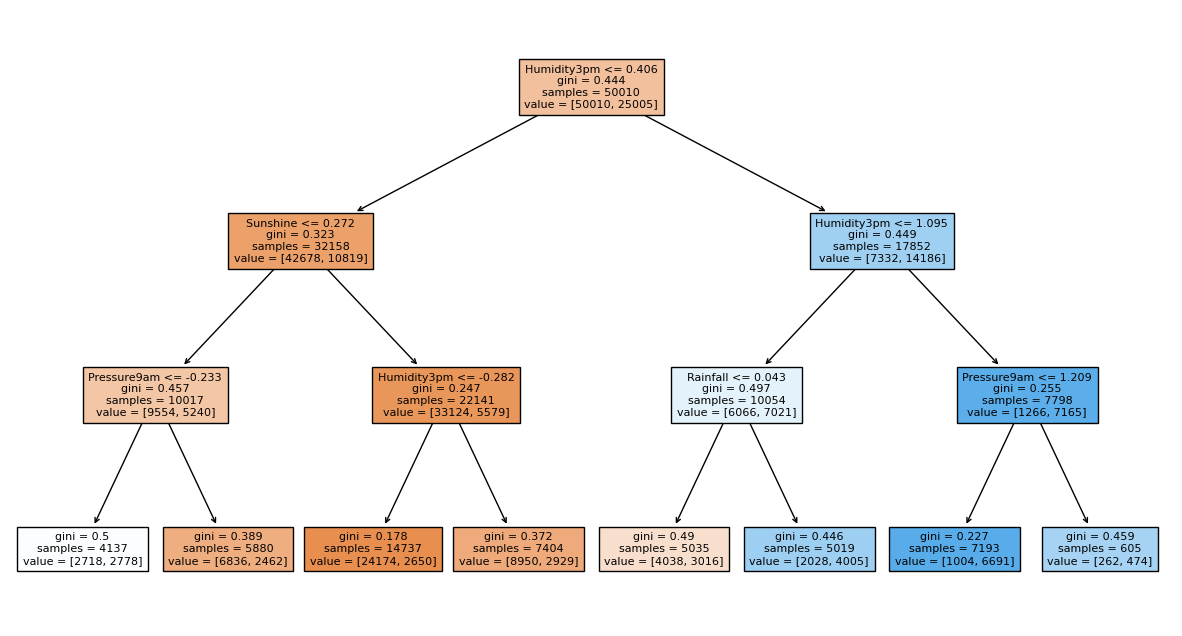

In [19]:
# représentation graphique de l'arbre de décision
plt.figure(figsize=(15,8))
plot_tree(clf_dt2, feature_names=X_train_scaled.columns.tolist(), filled=True, fontsize=8);

L'indice de diversité de **"Gini"** mesure la probabilité que l'arbre se trompe lors de la prise d'une décision. Il est compris entre 0 et 1 et atteint sa valeur minimale lorsque tous les éléments de l'ensemble sont dans une même classe de la variable-cible. 

Une autre alternative pour expliquer toutes les étapes dans un arbre de décision consiste à présenter le modèle comme du code parcourant de manière récursive les noeuds de l'arbre et affichant les règles de décision.

In [20]:
# définition de la fonction "tree_to_code()" permettant de générer une fonction Python "predict()" capable d'expliquer 
# les étapes de l'arbre de décision de manière algorithmique 
def tree_to_code(tree, feature_names):
    """
    Visualise un arbre de décision comme du code
    
    Paramètres:
    -----------
    tree: Modèle d'arbre de décision
    feature_names: liste des variables explicatives du modèle
    """

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

Le code *predict()* ci-dessous a été généré à partir de la fonction *tree_to_code()*. Il est ainsi très facile d'adapter cette fonction pour produire des règles de décision adaptées à n'importe quel language de programmation.

In [21]:
# création d'une fonction Python appliquant les règles de décision du modèle avec une profondeur de l'arbre spécifiée
tree_to_code(clf_dt2, feature_names=X_train_scaled.columns.tolist())

def predict(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.4063025265932083:
    if Sunshine <= 0.27219365537166595:
      if Pressure9am <= -0.23294904083013535:
        return [[2718. 2778.]]
      else:  # if Pressure9am > -0.23294904083013535
        return [[6836. 2462.]]
    else:  # if Sunshine > 0.27219365537166595
      if Humidity3pm <= -0.2821754962205887:
        return [[24174.  2650.]]
      else:  # if Humidity3pm > -0.2821754962205887
        return [[8950. 2929.]]
  else:  # if Humidity3pm > 0.4063025265932083
    if Humidity3pm <= 1.0947805643081665:
      if Rainfall <= 0.04319474473595619:
        return [[4038. 3016.]]
      else:  # if Rainfall > 0.04319474473595619
        return [[2028. 4005.]]
    else:  # if Humidity3pm > 1.0947805643081665
      if Pressure9am <= 1.209380865097046:
        return [[100

In [22]:
# création d'une fonction Python appliquant les règles de décision du modèle avec une profondeur de l'arbre non spécifiée
tree_to_code(clf_dt, feature_names=X_train_scaled.columns.tolist())

def predict(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.314505472779274:
    if Sunshine <= 0.27219365537166595:
      if Pressure9am <= -0.23294904083013535:
        if WindGustSpeed <= 0.6839991807937622:
          return [[1690. 1204.]]
        else:  # if WindGustSpeed > 0.6839991807937622
          return [[ 882. 1280.]]
      else:  # if Pressure9am > -0.23294904083013535
        if WindGustSpeed <= 0.24650075286626816:
          return [[5156. 1398.]]
        else:  # if WindGustSpeed > 0.24650075286626816
          return [[1196.  784.]]
    else:  # if Sunshine > 0.27219365537166595
      if Humidity3pm <= -0.3739725649356842:
        if WindGustSpeed <= 0.3923335671424866:
          return [[17534.  1199.]]
        else:  # if WindGustSpeed > 0.3923335671424866
          return [[5172. 1161.]]
      else:  # if Humi

Le code Python généré pour l'arbre de décision sans le paramètre *max_depth* apparait bien plus long et semble plus complexe, toutefois les règles de décisions restent faciles à suivre.

De cette manière, seulement quelques valeurs connues en entrée suffisent à l'utilisateur pour en déduire la probabilité des classes de la variable cible en sortie.